## AI core for Elly % Kate's snake

In [1]:

# # in google colab uncomment this

import os

os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.5.5')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=: 1


In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
game_name = 'Acrobot-v1'

In [4]:
env = gym.make(game_name).env
env.reset()

array([ 0.99992331,  0.01238415,  0.99929853, -0.03744918,  0.01334909,
        0.08418384])

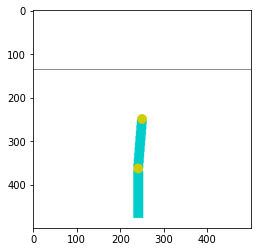

In [5]:
env = gym.make(game_name).env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

# building the network


![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/yet_another_week/_resource/qlearning_scheme.png)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
n_actions

3

In [0]:
network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim[0], 128)) # < ... >)
network.add_module('activation1', nn.ReLU())
network.add_module('layer2', nn.Linear(128, 64))
network.add_module('activation2', nn.ReLU())
network.add_module('layer3', nn.Linear(64, n_actions))
# <YOUR CODE: stack layers!!!1 >

# hint: use state_dim[0] as input size

In [0]:
s = env.reset()

In [10]:
s

array([ 0.99714477,  0.07551364,  0.99920385,  0.03989576,  0.07383475,
       -0.01636453])

In [11]:
network(torch.from_numpy(s).type(torch.FloatTensor))

tensor([ 0.0907, -0.0314,  0.1363], grad_fn=<AddBackward0>)

In [0]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = torch.tensor(state[None], dtype=torch.float32)
    q_values = network(state).detach().numpy()
    
    coin = np.random.random()
    
    if coin > epsilon:
        selected_action = np.argmax(q_values)
    else:
        selected_action = np.random.choice(np.arange(n_actions))

    # YOUR CODE

    return int(selected_action) # int( < epsilon-greedily selected action > )

In [13]:
s = env.reset()
assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (
    3, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules(
))[-1], nn.Linear), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(
    s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor 


In [0]:
def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(
        y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot


def where(cond, x_1, x_2):
    """ helper: like np.where but in pytorch. """
    return (cond * x_1) + ((1-cond) * x_2)

In [15]:
n_actions

3

In [0]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(
        states, dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.int32)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, state_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)
    is_done = torch.tensor(is_done, dtype=torch.float32)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = network(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(
        predicted_qvalues * to_one_hot(actions, n_actions), dim=1)

    # compute q-values for all actions in next states
    predicted_next_qvalues = network(next_states) # YOUR CODE

    # compute V*(next_states) using predicted next q-values
    
    with torch.no_grad():
        next_state_values = torch.max(predicted_next_qvalues, dim=1)[0] # YOUR CODE
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values # YOUR CODE

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = where(
        is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [0]:
# sanity checks
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)
loss = compute_td_loss([s], [a], [r], [next_s], [done], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(next(network.parameters()).grad.detach().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"

# Playing the game

In [0]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)
epsilon = 0.7

In [0]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)

        if train:
            opt.zero_grad()
            compute_td_loss([s], [a], [r], [next_s], [done]).backward()
            opt.step()

        total_reward += r
        s = next_s
        if done:
            break

    return total_reward

In [0]:
#from IPython.display import clear_output

#rewards = []
#for i in range(1000):
    #rewards.append(play_and_train(env, agent))
    #agent.epsilon *= 0.99

    #if i % 100 == 0:
        #clear_output(True)
        #print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        #plt.plot(rewards)
        
        #plt.show()

In [0]:
from IPython.display import clear_output
rewards = []


eps = 0.0001009413911679116 mean reward = -93.03


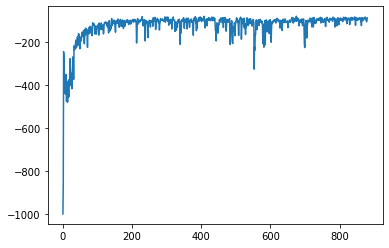

AssertionError: ignored

In [26]:
for i in range(1000):
    session_rewards = [generate_session(t_max= 1000,
        epsilon=epsilon, train=True) for _ in range(10)]
#     print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(
#         i, np.mean(session_rewards), epsilon))
    rewards.append(np.mean(session_rewards))
    clear_output(True)
    print('eps =', epsilon, 'mean reward =', np.mean(rewards[-10:]))
    plt.plot(rewards)
    plt.show()
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    if np.mean(session_rewards) > -50:
        print("AI wins the game, Snake sucks!")
        import gym.wrappers
        env = gym.wrappers.Monitor(gym.make(game_name),
                              directory="videos", force=True)
        generate_session(epsilon=0, train=False, t_max=1000)
        env.close()
        break

# recording sessions

In [0]:
import gym.wrappers

env = gym.wrappers.Monitor(gym.make(game_name),
                              directory="videos", force=True)
generate_session(epsilon=0, train=False, t_max=t_max)
env.close()

In [0]:
record_session(100)

In [52]:
!ls videos/

openaigym.episode_batch.2.124.stats.json
openaigym.manifest.2.124.manifest.json
openaigym.video.2.124.video000000.meta.json
openaigym.video.2.124.video000000.mp4


In [53]:
video_names

['openaigym.video.1.124.video000000.mp4',
 'openaigym.video.1.124.video000008.mp4',
 'openaigym.video.1.124.video000027.mp4',
 'openaigym.video.1.124.video000064.mp4',
 'openaigym.video.1.124.video000001.mp4']

In [54]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[0]))  # this may or may not be _last_ video. Try other indices

In [0]:
np.random.choice(np.arange(1, 17), size=5, replace=False)

In [0]:
torch.optim.lr_scheduler.ReduceLROnPlateau

In [0]:
torch.save(model.state_dict(), 'model_saved.pth')

In [0]:
nn.AdaptiveMaxPool1d()